In [16]:
class Leaf:

    def __init__(self, label):
        self.label = label
        print("Label: ",label)
        


class Decision_Node:

    def __init__(self, decision_boundary, greater_branch, smaller_branch):
        self.decision_boundary = decision_boundary
        self.greater_branch = greater_branch
        self.smaller_branch = smaller_branch

### Plotting steps and gains of LEVEL 1

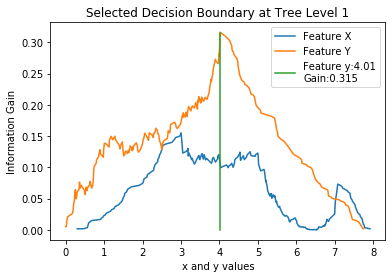

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
import numpy as np
import math
import operator #in order to sort python dictionary by values
import matplotlib.pyplot as plt

class PreProcessing(object):
    
    def readData(self, filepath, raw_length):
        with open(filepath) as fp:
            for i, line in enumerate(fp):
                x = line.split(",")
                x = np.array(x).reshape((1,raw_length))

                if i==0: 
                    data = x
                else:
                    data = np.concatenate((data,x),axis=0)       

        #print("Number of samples: ",data.shape[0])  
        
        return data
        
    def split_X_Y(self,data):
        numberOfFeatures = data.shape[1]-1
        numberOfSamples = data.shape[0]
        x = data[:,0:numberOfFeatures].reshape((numberOfSamples,numberOfFeatures))
        y = data[:,-1].reshape((numberOfSamples,1))
        #print("X Shape: ", x.shape)
        #print("Y Shape: ", y.shape)
        
        return x,y
        
        
    def createLabels(self): #This function must be changed according to data.
        zero = np.zeros((50,1))
        one = np.ones((50,1))
        two = np.ones((50,1))
        for i in range(50):
            two[i] = 2
        y= np.concatenate((zero,one,two),axis=0)    
        return y
        
            
#***********************************************************************************************************************
class DecisionTree(object):
    
    def __init__(self):
        self.counter = 0
        self.learned_parameters = {}
    
    def makeDictionary(self,x,y):
        dictionary = {}
        
        for i in range(x.shape[1]):
            dictionary[str(i)] = list(x[:,i])
        
        y = [np.asscalar(value) for value in list(y)]
        dictionary["label"] = list(y)
        
        return dictionary
    
    def filter(self, data, feature_id, step_value):
        
        #print("ın filter func type of feature_id",type(feature_id))
        #print("ın filter func type of step_value",type(step_value))
        
        smaller_values = {}
        greater_values = {}
        
        related_features = data[str(feature_id)]
        copy_id_small = []
        copy_id_great = []
        
        for idx, single_feature_value in enumerate(related_features):
            
            if single_feature_value > step_value:
                copy_id_great.append(idx)

            if single_feature_value < step_value:
                copy_id_small.append(idx)
                
        #Not: bu noktada epsilonu en küçük değerli featuredan çıkardığımız için small 0 elemanlı olabilir. Soruna yol açabilir!
        #**************************************************           
        for column_id in range(len(data)-1):#filitrelenen idli featurelar kopyalanyor.
            copy_column = []
            for idx in copy_id_small: 
                column = data[str(column_id)]
                copy_column.append(column[idx])
            smaller_values[str(column_id)] = copy_column
            
        
        copy_column = []
        
        for idx in copy_id_small: #filitrelenen idli labellar kopyalanyor.
            column = data["label"]
            copy_column.append(column[idx])
        smaller_values["label"] = copy_column
    
        #**************************************************
        for column_id in range(len(data)-1):#filitrelenen idli featurelar kopyalanyor.
            copy_column = []
            for idx in copy_id_great: 
                column = data[str(column_id)]
                copy_column.append(column[idx])
            greater_values[str(column_id)] = copy_column
            
        
        copy_column = []
        
        for idx in copy_id_great: #filitrelenen idli labellar kopyalanyor.
            column = data["label"]
            copy_column.append(column[idx])
        greater_values["label"] = copy_column
        #*************************************************
        
        return greater_values, smaller_values
    
    
    def CountLabels(self,greater_label,set_of_labels):
        counts_of_greater_labels = []
        for value in (set_of_labels):
            counter = 0
            for label in (greater_label):
                if value==label:
                    counter = counter + 1
            counts_of_greater_labels.append(counter)
        
        return counts_of_greater_labels
    
    
    
    def InformationGain(self,greater_values, smaller_values, data):
        
        greater_label = greater_values["label"]
        smaller_label = smaller_values["label"]
                
        set_of_greater_labels = sorted(set(greater_label))
        set_of_smaller_labels = sorted(set(smaller_label))
        
        counts_of_greater_labels = self.CountLabels(greater_label,set_of_greater_labels)
        counts_of_smaller_labels = self.CountLabels(smaller_label,set_of_smaller_labels)
        counts_of_total_labels = sum(counts_of_greater_labels) + sum(counts_of_smaller_labels)
        greater_probabilities = [value/sum(counts_of_greater_labels) for value in counts_of_greater_labels]
        smaller_probabilities = [value/sum(counts_of_smaller_labels) for value in counts_of_smaller_labels]
        
        greater_entropy = 0
        smaller_entropy = 0
        
        for prob in (greater_probabilities):
            greater_entropy = greater_entropy - math.log(prob,2)*prob

        for prob in (smaller_probabilities):
            smaller_entropy = smaller_entropy - math.log(prob,2)*prob
        
        right_side_formula = (sum(counts_of_smaller_labels)/counts_of_total_labels)*smaller_entropy + (sum(counts_of_greater_labels)/counts_of_total_labels)*greater_entropy
        
        #E(s)
        data_label = data["label"]
        set_of_data_labels = sorted(set(data_label))
        counts_of_data_labels = self.CountLabels(data_label,set_of_data_labels)
        data_probabilities = [value/sum(counts_of_data_labels) for value in counts_of_data_labels]
     
        data_entropy = 0
        
        for prob in (data_probabilities):
            data_entropy = data_entropy - math.log(prob,2)*prob
            
        gain = data_entropy - right_side_formula

        return gain
    
    
        
    def detectImportantFeatures(self,data,epsilon): 
        
        featureID_gain = {}
        featureID_decisionBoundary = {}
        
        dict0 = {}
        dict1 = {}
        
        for feature_id in range(len(data)-1): #tüm featurelarda gezer ve en uygun sınır değerini bulur.
            
            #print("\nFeature {} için en uygun sınır değeri aranıyor.".format(feature_id))
            
            single_feature = data[str(feature_id)] #feature column
            steps = sorted(set(single_feature))
            steps = [value-epsilon for value in steps] #her feature değerinden epsilon kadar çıkarır
            steps[0] = steps[0] + 2*epsilon #ilk elemanın solunda kalırsa boş küme oluşur, recursive bozulur.
            
            step_values_and_gains = {}
            
            for step_value in steps:#her featureın içinde gezerken birçok step ile entropy hesabı yapılır. 
                                    # minimum entropyi veren step_value = learned parameter for special feature
                greater_values, smaller_values = self.filter(data, feature_id, step_value)
                gain = self.InformationGain(greater_values, smaller_values, data)
                step_values_and_gains[step_value] = gain
                
                if feature_id==0:
                    dict0[step_value] = gain
                if feature_id==1:
                    dict1[step_value] = gain
                    
                    
            sorted_entropies_and_step_values = sorted(step_values_and_gains.items(), key=operator.itemgetter(1))             
            decision_boundary, max_gain = sorted_entropies_and_step_values[-1] #gain en yüksek olan sınır değeri 
            featureID_gain[feature_id] = max_gain #(decision_boundary, entropy)
            featureID_decisionBoundary[feature_id] = decision_boundary
            
        sorted_featureIDs_gains = sorted(featureID_gain.items(), key=operator.itemgetter(1))#her feature sahip olduğu gaine
                                                                         #göre sırlandı    
        
        best_feature, max_gain = sorted_featureIDs_gains[-1] #select the feature which has max gain
        decision_Boundary = featureID_decisionBoundary[best_feature]
        
        
        #print("\nSorted FeatureID and gains by gain: ", sorted_featureIDs_gains)

        #print("Feature IDs and decision boundaries: ",featureID_decisionBoundary)

        return dict0, dict1 #best_feature, max_gain, decision_Boundary
          
        
        
        
        
        
    def BuildTree(self, data):
        #print("Main data: ",data)
        #print("counter: ", self.counter)
        self.counter = self.counter + 1
        #print("Label count: ",len(set(data["label"])))
        #print("Sample count: ",len(data["label"]))
        
      
        #LABEL COUNT CHECK
        if len(set(data["label"])) == 1 or 0:
            label = list(set(data["label"]))[0]
            print("leaf is ready")
            #print("***********************************")
            return Leaf(label)
      
        #BUNDARY AND FEATURE DETECTION
        feature, max_gain, decision_Boundary = self.detectImportantFeatures(data, epsilon=0.001)
        
        print("Information Gain: ",max_gain)
        print("Feature Id: ", feature )
        print("Decision Boundary: ", decision_Boundary)
        
        
        #SPLIT DATA
        greater_values, smaller_values = self.filter(data, feature, decision_Boundary)
        #print("Sample count in the greater data: ",len(greater_values["label"]))
        #print("Sample count in the smaller data: ",len(smaller_values["label"]))
        #print("greater values :",greater_values)
        #print("smaller values :",smaller_values)
        print("********************")
       
        #CREATE NODE
        greater_Node = self.BuildTree(greater_values)
        smaller_Node = self.BuildTree(smaller_values)
        
        return Decision_Node(decision_Boundary, greater_Node, smaller_Node)
    
    
    

    def fit(self,x,y):
        data = self.makeDictionary(x,y) #tüm datalar list
        dict0, dict1 = self.detectImportantFeatures(data, epsilon=0.001)
        
        #tree = self.BuildTree(data)
        return dict0, dict1


#MAIN****************************************************************************
preprocessing = PreProcessing()
filepath = 'data\data.txt'
data = preprocessing.readData(filepath,3)
x, y = preprocessing.split_X_Y(data)
x = np.float32(x)


model = DecisionTree()
dict0, dict1 = model.fit(x,y)

feature0_steps = list(dict0.keys())
feature0_gains = list(dict0.values())
feature1_steps = list(dict1.keys())
feature1_gains = list(dict1.values())


plt.plot(feature0_steps, feature0_gains, label = "Feature X")
plt.plot(feature1_steps, feature1_gains, label = "Feature Y")
plt.legend()
plt.title("Selected Decision Boundary at Tree Level 1")
x_coordinates = [4.01,4.01]
y_coordinates = [0,0.315]
plt.plot(x_coordinates, y_coordinates, label = "Feature y:4.01\nGain:0.315")
plt.legend()
plt.xlabel("x and y values")
plt.ylabel("Information Gain")

plt.show()
plt.figure()




Text(0, 0.5, 'y')

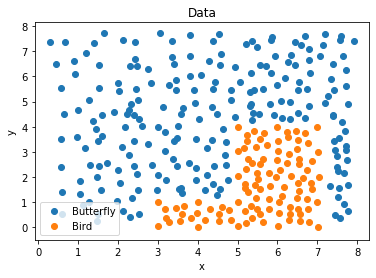

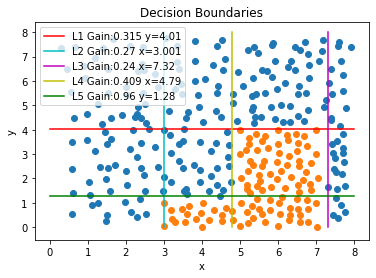

In [18]:
bird = []
butterfly = []
for i in range(len(x)):
    if y[i]=="1\n":
        bird.append(x[i])
    if y[i]=="2\n":
        butterfly.append(x[i])
butterfly = np.array(butterfly) 
bird = np.array(bird)


plt.scatter(butterfly[:,0],butterfly[:,1], label="Butterfly")
plt.scatter(bird[:,0],bird[:,1], label ="Bird")
plt.title("Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.figure()

plt.title("Decision Boundaries")
plt.scatter(butterfly[:,0],butterfly[:,1])
plt.scatter(bird[:,0],bird[:,1])

x_coordinates = [0, 8]
y_coordinates = [4.01, 4.01]
plt.plot(x_coordinates, y_coordinates, "r", label = "L1 Gain:0.315 y=4.01")
plt.legend()

x_coordinates = [3,3]
y_coordinates = [0,8]
plt.plot(x_coordinates, y_coordinates, "c", label = "L2 Gain:0.27 x=3.001")
plt.legend()

x_coordinates = [7.32,7.32]
y_coordinates = [0,8]
plt.plot(x_coordinates, y_coordinates, "m", label = "L3 Gain:0.24 x=7.32")
plt.legend()

x_coordinates = [4.79, 4.79]
y_coordinates = [0,8]
plt.plot(x_coordinates, y_coordinates, "y", label = "L4 Gain:0.409 x=4.79")
plt.legend()

x_coordinates = [0,8]
y_coordinates = [1.28, 1.28]
plt.plot(x_coordinates, y_coordinates, "g", label = "L5 Gain:0.96 y=1.28")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

In [2]:
import numpy as np
import math
import operator #in order to sort python dictionary by values
import matplotlib.pyplot as plt

class PreProcessing(object):
    
    def readData(self, filepath, raw_length):
        with open(filepath) as fp:
            for i, line in enumerate(fp):
                x = line.split(",")
                x = np.array(x).reshape((1,raw_length))

                if i==0: 
                    data = x
                else:
                    data = np.concatenate((data,x),axis=0)       

        #print("Number of samples: ",data.shape[0])  
        
        return data
        
    def split_X_Y(self,data):
        numberOfFeatures = data.shape[1]-1
        numberOfSamples = data.shape[0]
        x = data[:,0:numberOfFeatures].reshape((numberOfSamples,numberOfFeatures))
        y = data[:,-1].reshape((numberOfSamples,1))
        #print("X Shape: ", x.shape)
        #print("Y Shape: ", y.shape)
        
        return x,y
        
        
    def createLabels(self): #This function must be changed according to data.
        zero = np.zeros((50,1))
        one = np.ones((50,1))
        two = np.ones((50,1))
        for i in range(50):
            two[i] = 2
        y= np.concatenate((zero,one,two),axis=0)    
        return y
        
            
#***********************************************************************************************************************
class DecisionTree(object):
    
    def __init__(self):
        self.counter = 0
        self.learned_parameters = {}
    
    def makeDictionary(self,x,y):
        dictionary = {}
        
        for i in range(x.shape[1]):
            dictionary[str(i)] = list(x[:,i])
        
        y = [np.asscalar(value) for value in list(y)]
        dictionary["label"] = list(y)
        
        return dictionary
    
    def filter(self, data, feature_id, step_value):
        
        #print("ın filter func type of feature_id",type(feature_id))
        #print("ın filter func type of step_value",type(step_value))
        
        smaller_values = {}
        greater_values = {}
        
        related_features = data[str(feature_id)]
        copy_id_small = []
        copy_id_great = []
        
        for idx, single_feature_value in enumerate(related_features):
            
            if single_feature_value > step_value:
                copy_id_great.append(idx)

            if single_feature_value < step_value:
                copy_id_small.append(idx)
                
        #Not: bu noktada epsilonu en küçük değerli featuredan çıkardığımız için small 0 elemanlı olabilir. Soruna yol açabilir!
        #**************************************************           
        for column_id in range(len(data)-1):#filitrelenen idli featurelar kopyalanyor.
            copy_column = []
            for idx in copy_id_small: 
                column = data[str(column_id)]
                copy_column.append(column[idx])
            smaller_values[str(column_id)] = copy_column
            
        
        copy_column = []
        
        for idx in copy_id_small: #filitrelenen idli labellar kopyalanyor.
            column = data["label"]
            copy_column.append(column[idx])
        smaller_values["label"] = copy_column
    
        #**************************************************
        for column_id in range(len(data)-1):#filitrelenen idli featurelar kopyalanyor.
            copy_column = []
            for idx in copy_id_great: 
                column = data[str(column_id)]
                copy_column.append(column[idx])
            greater_values[str(column_id)] = copy_column
            
        
        copy_column = []
        
        for idx in copy_id_great: #filitrelenen idli labellar kopyalanyor.
            column = data["label"]
            copy_column.append(column[idx])
        greater_values["label"] = copy_column
        #*************************************************
        
        return greater_values, smaller_values
    
    
    def CountLabels(self,greater_label,set_of_labels):
        counts_of_greater_labels = []
        for value in (set_of_labels):
            counter = 0
            for label in (greater_label):
                if value==label:
                    counter = counter + 1
            counts_of_greater_labels.append(counter)
        
        return counts_of_greater_labels
    
    
    
    def InformationGain(self,greater_values, smaller_values, data):
        
        greater_label = greater_values["label"]
        smaller_label = smaller_values["label"]
                
        set_of_greater_labels = sorted(set(greater_label))
        set_of_smaller_labels = sorted(set(smaller_label))
        
        counts_of_greater_labels = self.CountLabels(greater_label,set_of_greater_labels)
        counts_of_smaller_labels = self.CountLabels(smaller_label,set_of_smaller_labels)
        counts_of_total_labels = sum(counts_of_greater_labels) + sum(counts_of_smaller_labels)
        greater_probabilities = [value/sum(counts_of_greater_labels) for value in counts_of_greater_labels]
        smaller_probabilities = [value/sum(counts_of_smaller_labels) for value in counts_of_smaller_labels]
        
        greater_entropy = 0
        smaller_entropy = 0
        
        for prob in (greater_probabilities):
            greater_entropy = greater_entropy - math.log(prob,2)*prob

        for prob in (smaller_probabilities):
            smaller_entropy = smaller_entropy - math.log(prob,2)*prob
        
        right_side_formula = (sum(counts_of_smaller_labels)/counts_of_total_labels)*smaller_entropy + (sum(counts_of_greater_labels)/counts_of_total_labels)*greater_entropy
        
        #E(s)
        data_label = data["label"]
        set_of_data_labels = sorted(set(data_label))
        counts_of_data_labels = self.CountLabels(data_label,set_of_data_labels)
        data_probabilities = [value/sum(counts_of_data_labels) for value in counts_of_data_labels]
     
        data_entropy = 0
        
        for prob in (data_probabilities):
            data_entropy = data_entropy - math.log(prob,2)*prob
            
        gain = data_entropy - right_side_formula

        return gain
    
    
        
    def detectImportantFeatures(self,data,epsilon): 
        
        featureID_gain = {}
        featureID_decisionBoundary = {}
    
        
        for feature_id in range(len(data)-1): #tüm featurelarda gezer ve en uygun sınır değerini bulur.
            
            #print("\nFeature {} için en uygun sınır değeri aranıyor.".format(feature_id))
            
            single_feature = data[str(feature_id)] #feature column
            steps = sorted(set(single_feature))
            steps = [value-epsilon for value in steps] #her feature değerinden epsilon kadar çıkarır
            steps[0] = steps[0] + 2*epsilon #ilk elemanın solunda kalırsa boş küme oluşur, recursive bozulur.
            
            step_values_and_gains = {}
            
            for step_value in steps:#her featureın içinde gezerken birçok step ile entropy hesabı yapılır. 
                                    # minimum entropyi veren step_value = learned parameter for special feature
                greater_values, smaller_values = self.filter(data, feature_id, step_value)
                gain = self.InformationGain(greater_values, smaller_values, data)
                step_values_and_gains[step_value] = gain
                                    
                    
            sorted_entropies_and_step_values = sorted(step_values_and_gains.items(), key=operator.itemgetter(1))             
            decision_boundary, max_gain = sorted_entropies_and_step_values[-1] #gain en yüksek olan sınır değeri 
            featureID_gain[feature_id] = max_gain #(decision_boundary, entropy)
            featureID_decisionBoundary[feature_id] = decision_boundary
            
        sorted_featureIDs_gains = sorted(featureID_gain.items(), key=operator.itemgetter(1))#her feature sahip olduğu gaine
                                                                         #göre sırlandı    
        
        best_feature, max_gain = sorted_featureIDs_gains[-1] #select the feature which has max gain
        decision_Boundary = featureID_decisionBoundary[best_feature]
        
        
        #print("\nSorted FeatureID and gains by gain: ", sorted_featureIDs_gains)

        #print("Feature IDs and decision boundaries: ",featureID_decisionBoundary)

        return best_feature, max_gain, decision_Boundary
          
        
        
        
        
        
    def BuildTree(self, data):
        #print("Main data: ",data)
        print("counter: ", self.counter)
        self.counter = self.counter + 1
        print("Label count: ",len(set(data["label"])))
        print("Sample count: ",len(data["label"]))
        
      
        #LABEL COUNT CHECK
        if len(set(data["label"])) == 1 or 0:
            label = list(set(data["label"]))[0]
            print("leaf is ready")
            print("***********************************")
            return Leaf(label)
      
        #BUNDARY AND FEATURE DETECTION
        feature, max_gain, decision_Boundary = self.detectImportantFeatures(data, epsilon=0.001)
        
        print("Information Gain: ",max_gain)
        print("Feature Id: ", feature )
        print("Decision Boundary: ", decision_Boundary)
        
        
        #SPLIT DATA
        greater_values, smaller_values = self.filter(data, feature, decision_Boundary)
        print("Sample count in the greater data: ",len(greater_values["label"]))
        print("Sample count in the smaller data: ",len(smaller_values["label"]))
        #print("greater values :",greater_values)
        #print("smaller values :",smaller_values)
        print("********************")
       
        #CREATE NODE
        greater_Node = self.BuildTree(greater_values)
        smaller_Node = self.BuildTree(smaller_values)
        
        return Decision_Node(decision_Boundary, greater_Node, smaller_Node)
    
    
    

    def fit(self,x,y):
        data = self.makeDictionary(x,y) #tüm datalar list
        tree = self.BuildTree(data)
        return tree


#MAIN****************************************************************************
preprocessing = PreProcessing()
filepath = 'data.txt'
data = preprocessing.readData(filepath,3)
x, y = preprocessing.split_X_Y(data)
x = np.float32(x)


model = DecisionTree()
tree = model.fit(x,y)





counter:  0
Label count:  2
Sample count:  312
Information Gain:  0.31597083060209075
Feature Id:  1
Decision Boundary:  4.019318031311035
Sample count in the greater data:  125
Sample count in the smaller data:  187
********************
counter:  1
Label count:  1
Sample count:  125
leaf is ready
***********************************
Label:  2

counter:  2
Label count:  2
Sample count:  187
Information Gain:  0.2774363684880765
Feature Id:  0
Decision Boundary:  3.0034169425964357
Sample count in the greater data:  149
Sample count in the smaller data:  38
********************
counter:  3
Label count:  2
Sample count:  149
Information Gain:  0.24354735331494592
Feature Id:  0
Decision Boundary:  7.323204921722412
Sample count in the greater data:  19
Sample count in the smaller data:  130
********************
counter:  4
Label count:  1
Sample count:  19
leaf is ready
***********************************
Label:  2

counter:  5
Label count:  2
Sample count:  130
Information Gain:  0.40996

### Scikit Learn Decision Tree

In [19]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = "entropy")
clf = clf.fit(x, y)
print(clf)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


[Text(223.20000000000002, 199.32, 'X[1] <= 4.007\nentropy = 0.912\nsamples = 312\nvalue = [102, 210]'),
 Text(167.4, 163.07999999999998, 'X[0] <= 3.0\nentropy = 0.994\nsamples = 187\nvalue = [102, 85]'),
 Text(111.60000000000001, 126.83999999999999, 'entropy = 0.0\nsamples = 38\nvalue = [0, 38]'),
 Text(223.20000000000002, 126.83999999999999, 'X[0] <= 7.183\nentropy = 0.899\nsamples = 149\nvalue = [102, 47]'),
 Text(167.4, 90.6, 'X[0] <= 4.78\nentropy = 0.752\nsamples = 130\nvalue = [102, 28]'),
 Text(111.60000000000001, 54.359999999999985, 'X[1] <= 1.145\nentropy = 0.966\nsamples = 46\nvalue = [18, 28]'),
 Text(55.800000000000004, 18.119999999999976, 'entropy = 0.0\nsamples = 18\nvalue = [18, 0]'),
 Text(167.4, 18.119999999999976, 'entropy = 0.0\nsamples = 28\nvalue = [0, 28]'),
 Text(223.20000000000002, 54.359999999999985, 'entropy = 0.0\nsamples = 84\nvalue = [84, 0]'),
 Text(279.0, 90.6, 'entropy = 0.0\nsamples = 19\nvalue = [0, 19]'),
 Text(279.0, 163.07999999999998, 'entropy = 0.

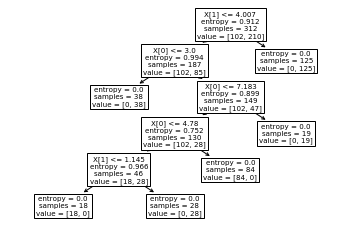

In [20]:
tree.plot_tree(clf) 